### Introduction
The goal of this notebook is to learn how to run a cosmological N-body simulation. If you take a moment to think about it, the idea is quite straightforward:

1. Start with the initial conditions $[\vec{x_i},\vec{v_i},m_i]$ for each particle.
2. Compute the gravitational force acting on each particle.
3. Choose an appropriate time step and update $[\vec{x_i},\vec{v_i}]$ for each particle using the equations of motion.
4. Repeat steps 2 and 3 until the desired epoch is reached.

From the lectures, you’ve learned that there are several methods for calculating gravitational forces, such as tree codes and particle-mesh methods. In the previous notebook, you mastered how to compute the force field by obtaining the potential in Fourier space using mesh cells. In this notebook, we will adopt the particle-mesh method for force calculation.


In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

import sheet_unfolding.sim as sim
from matplotlib.colors import LogNorm

## CIC for Density Estimation

In the last notebook, we skipped the density estimation step by using the linear density field, which is a built-in function in `sim.ic.IC2DCosmo()`. In the first notebook, we actually calculated the density by simply counting the number of particles in each cell. This method is known as the particle-in-cell (PIC) or nearest grid point (NGP) method for density estimation. It is simple, fast, and has been widely used in research.

However, PIC can produce discontinuities between adjacent cells. Also, in simulations, we often have a single DM particle with mass $\gtrsim 10^6\,M_{\odot}$, so modeling all the mass as being concentrated at a single point is not ideal for estimating the overdensity.

In this subsection, we will explore the Clouds-in-Cells (CIC) method for density estimation and compare it with PIC. The idea is, assume the mass is distributed in a square (for 2d) of the same size as the grid, and the mass can be attributed to at most 4 cells depending on how much the square overlap with the cells. In this way we can avoid the discontinuity and the point-mass problem.

### Goal
Make a plot comparing the CIC overdensities with a normal histogram for a Zel'dovich approximation at $a=0.05$ and $a=0.5$.

In [2]:
def cic_density(pos, mass=1., L=100., ngrid=128):
    xred = (pos%L) / (L / ngrid)
    ired = np.int64(np.floor(xred))
    dx = xred - ired
    rhogrid = 0.
    
    bins = np.arange(0, ngrid+1)
    
    for ix in (0,1):
        for iy in (0,1):
            weight = np.abs(1-ix-dx[...,0])*np.abs(1-iy-dx[...,1]) * mass
            idep = (xred + np.array((ix, iy))) % ngrid
            rhonew,_ = np.histogramdd(idep.reshape(-1,2), bins=(bins, bins), weights=weight.reshape(-1))
            rhogrid += rhonew
            
    V = (L/ngrid)**2 
    
    return rhogrid / V

def histogram_density(pos, mass=1., L=100., ngrid=128):
    V = (L/ngrid)**2
    
    bins = np.linspace(0, L, ngrid+1)
    h,_ = np.histogramdd(pos.reshape(-1,2)%L, bins=(bins, bins), weights=mass*np.ones(pos.shape[:-1]).flatten())
    return h / V

In [3]:
aini = 0.1
L = 100.
myic = sim.ic.IC2DCosmo(128, sL=L, aic=aini, rs=0.5, vec3d=True, Omega_m=1.)
pos = myic.get_x(a=0.05)

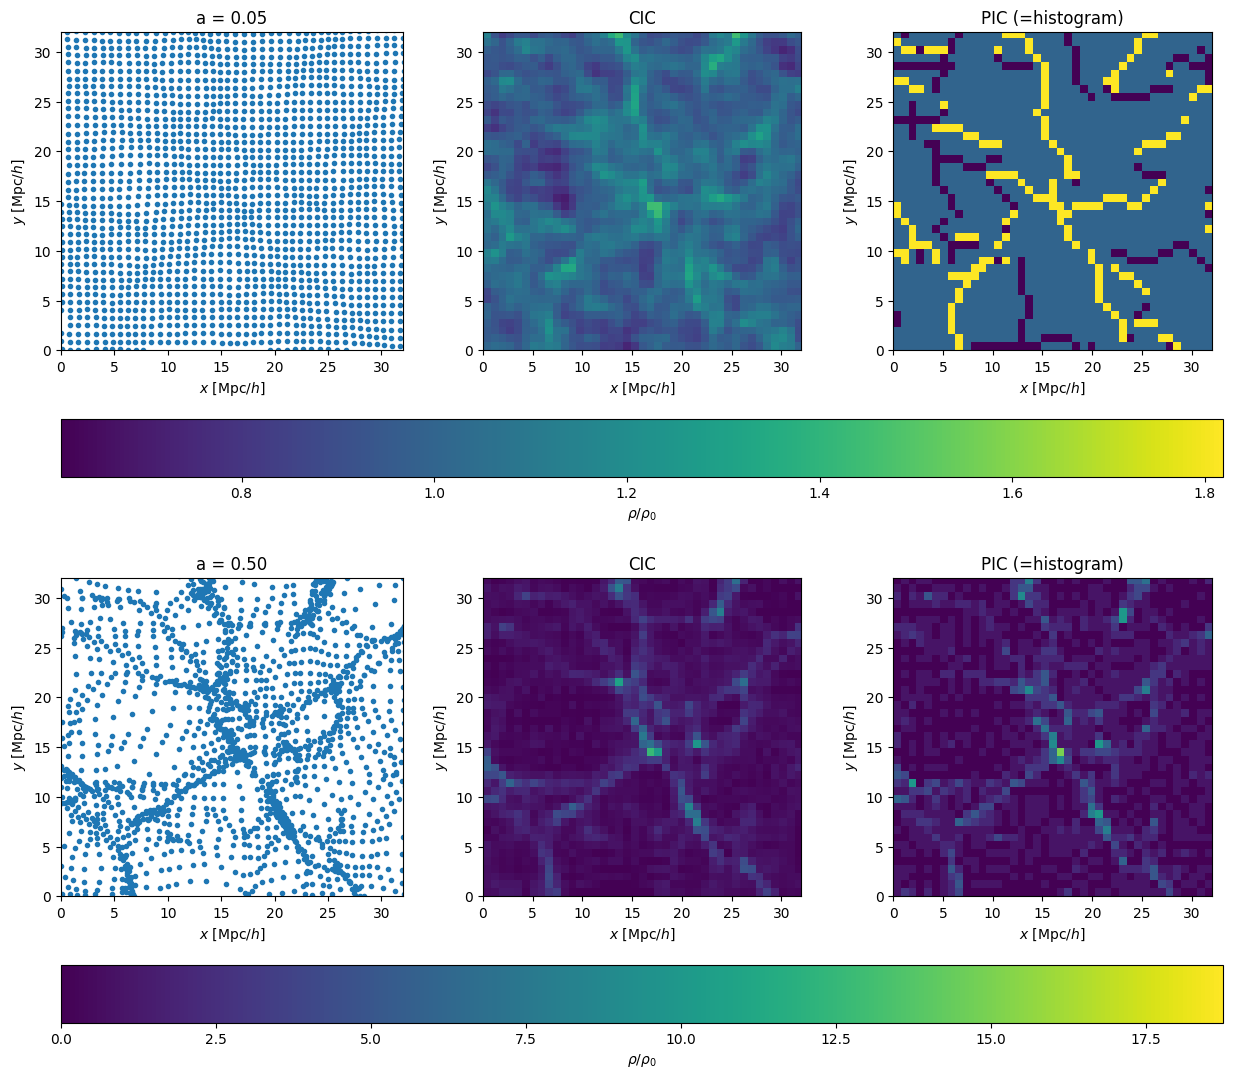

In [6]:
fig, axs = plt.subplots(2,3, figsize=(15,13))

from matplotlib.colors import LogNorm

for i, a in enumerate([0.05,0.5]):
    pos = myic.get_x(a=a)[...,0:2]
    axs[i,0].scatter(pos[...,0], pos[...,1], marker=".")
    rhocic = cic_density(pos)
    rhohist = histogram_density(pos)
    vmin, vmax = np.min(rhocic)/ np.mean(rhocic), np.max(rhocic)/ np.mean(rhocic)
    # vmin, vmax = np.min(rhohist)/ np.mean(rhohist), np.max(rhohist)/ np.mean(rhohist)
    im = axs[i,1].imshow(rhocic.T / np.mean(rhocic), origin="lower", extent=[0,L,0,L], vmin=vmin, vmax=vmax)
    axs[i,2].imshow(rhohist.T / np.mean(rhohist), origin="lower", extent=[0,L,0,L], vmin=vmin, vmax=vmax)
    plt.colorbar(im, ax=axs[i,:], orientation="horizontal", label=r"$\rho/ \rho_0$")
    
    axs[i,0].set_title("a = %.2f" % a)
    axs[i,1].set_title("CIC")
    axs[i,2].set_title("PIC (=histogram)")

for ax in axs.flat:
    ax.set_xlim(0,32)
    ax.set_ylim(0,32)
    ax.set_xlabel(r"$x$ [Mpc/$h$]")
    ax.set_ylabel(r"$y$ [Mpc/$h$]")
    
plt.savefig("img/nbody_cic_assignment.png", bbox_inches="tight")

## Force and Acceleration Field

Now you have the overdensity field from CIC estimation, we can calculate the potential field and the acceleration field as demonstrated in the second notebook. 

**Note**: Don't normalize the density to the mean here since you need the actual $\rho$ rather than the overdensity in the Possion's equation.

In [7]:
def force_field(pos, mass=1., L=100., ngrid=128, G=1.):
    rho = cic_density(pos, mass=mass, L=L, ngrid=ngrid)
    rhok = np.fft.fft2(rho)
    
    kvec = sim.ic.get_kmesh((ngrid, ngrid), L)
    kabs = np.sqrt(np.sum(kvec**2, axis=-1))

    phi_k = - 4 * np.pi * G * rhok / np.clip(kabs, 1e-20, None)**2
    phi_k[0,0] = 0.
    phi = np.real(np.fft.ifft2(phi_k))

    acc_k = -1j * kvec * phi_k[...,np.newaxis]
    acc = np.real(np.fft.ifft2(acc_k, axes=(0,1)))
    
    return acc

In [8]:
pos = myic.get_x(a=0.5)[...,0:2]
acc_field = force_field(pos.reshape(-1,2), ngrid=256, mass=1., G=1.)
print(pos.shape, acc_field.shape)

(128, 128, 2) (256, 256, 2)


# Interpolate the acceleration field

Now you have the acceleration field calculated on grid cells, there is one more thing to consider. What we need to know is the accelaration at the particle positions rather than the cell center positions. Should two particles in the same grid cell have the same acceleration when one is at the very left of the cell while the other is at the very right? The answer is no, you should do a linear interpolation of the acceleration field to get the acceleration at arbituary positions. You can simply use `sim.sim.linear_interp2d()` for this. However, please have a look at the corresponding source code, so that you understand how the interpolation works

Check that you get the same values as follows.

In [9]:
np.random.seed(42)
xtest = np.random.uniform(0,L, (5,2))
print("x=", xtest)
print("a=",sim.sim.linear_interp2d(acc_field, xtest, L))

x= [[37.45401188 95.07143064]
 [73.19939418 59.86584842]
 [15.60186404 15.59945203]
 [ 5.80836122 86.61761458]
 [60.11150117 70.80725778]]
a= [[-38.08094377 -54.14098941]
 [-14.63374373  -2.98440794]
 [ 73.22377149   9.80425456]
 [ 17.33515369 -23.99716875]
 [ 14.38940242  55.56423101]]


# Create a single function that takes the N-body positions and outputs the N-body forces

In [10]:
def nbody_forces(pos, mass=1., L=100., ngrid=128, G=1.):
    acc_field = force_field(pos=pos, mass=mass, L=L, ngrid=ngrid, G=G)
    
    acc_at_pos = sim.sim.linear_interp2d(acc_field, pos, L)
    
    return acc_at_pos

In [11]:
pos = myic.get_x(a=0.5)[...,0:2]
nbody_forces(pos, ngrid=256).shape

(128, 128, 2)

## Make an N-body simulation

We have to integrate the equations of motion

\begin{align}
  \frac{d\vec{x}}{da} &= \frac{1}{a^3 H(a)} \vec{v}\\
  \frac{d\vec{v}}{da} &= \frac{1}{a^2 H(a)} \vec{a}
\end{align}
where the vector $\vec{a}$  is the acceleration (the scalar $a$ is the scale factor), $\vec{v}$ the velocity and $\vec{x}$ the position of the particles. These are all given in comoving space, we can discuss this later. H(a) is the Hubble function which in our case (Einstein-de-Sitter universe) is given by
\begin{align}
  H(a) &= 100 a^{3/2}
\end{align}
(units $[h\,\, \mathrm{km/s/Mpc}]$)

To get all the units right, it is important that you pass the masses to the CIC assignment. Further, you need to use 
\begin{align}
  G=43.0071057317063e-10
\end{align}
which is the Gravitational constant when using units of $[\mathrm{Mpc}^3\mathrm{(km/s)}^2\mathrm{M_\odot}^{-1}]$.

Also don't for get to wrap all positions between [0, L] after each step (periodic boundary conditions!!) you can do this by setting
pos = pos % L

### Setup:
start at $a=0.05$, use steps of size $da=0.01$, use a Euler integrator, and ngrid=256 for the force calculation. Plot the particle distribution at the epoch given in the following figures to make comparisons.

In [12]:
L = 100.
myic = sim.ic.IC2DCosmo(128, L=L, rs=0.5, vec3d=True, Omega_m=1.)
pos,vel, mass = myic.get_particles(a = 0.05)  
pos, vel = pos[...,0:2], vel[...,0:2]

output_steps = [0,5,25,55,95]
a = 0.05
i, da = 0, 0.01

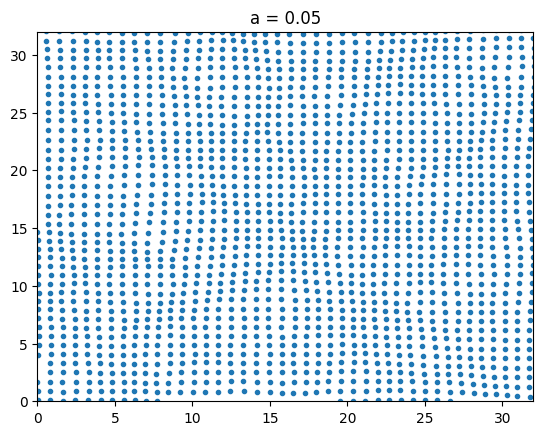

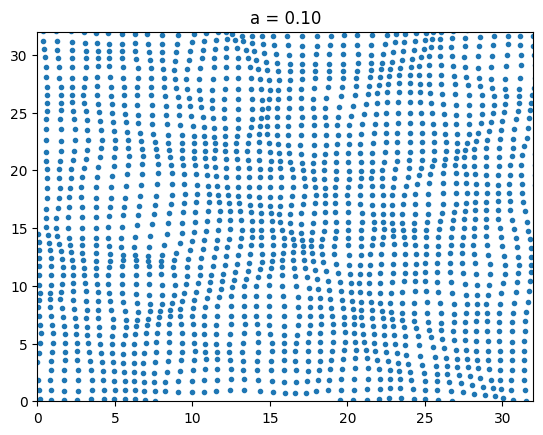

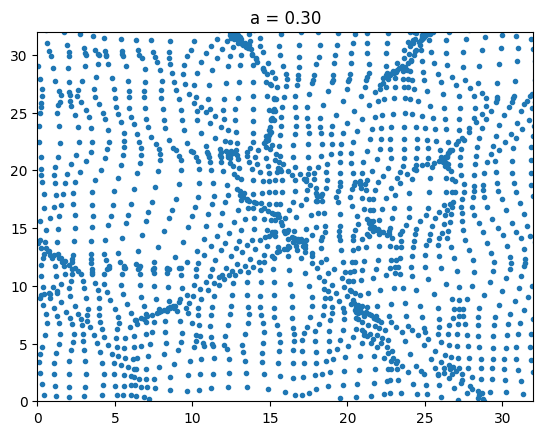

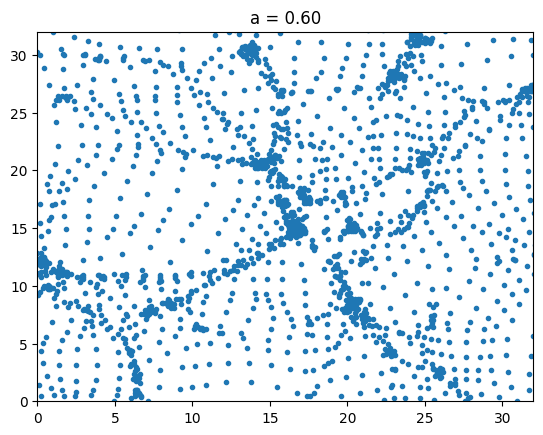

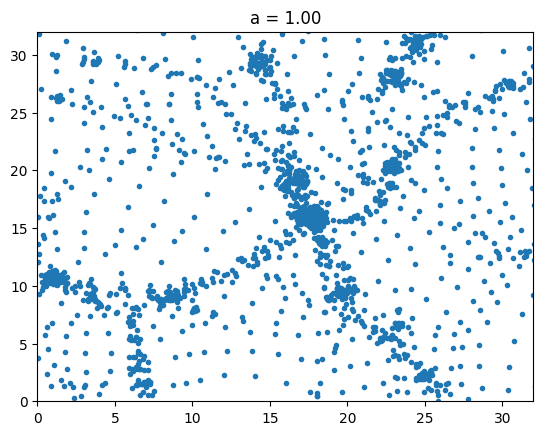

In [13]:
while a <= 1.01:
    if i in output_steps:
        plt.figure()
        plt.scatter(pos[...,0].flatten(), pos[...,1].flatten(), marker=".")
        plt.xlim(0,32)
        plt.ylim(0,32)
        plt.title("a = %.2f" % a)
        plt.savefig("img/nbody_a%.2f.png" % a)
        
    H = 100. * a**(-3/2.)
    driftfac = da/a**2 / (a*H)
    kickfac = da/a / (a*H)
    
    pos = (pos + vel * driftfac) %L
    acc = nbody_forces(pos, mass=mass, L=L, ngrid=256, G=43.0071057317063e-10)
    vel += acc * kickfac
    a += da
    i += 1